In [183]:
import numpy as np
import pandas as pd
import scipy.stats
import warnings
warnings.filterwarnings(action='ignore')

####  1. Выберите подвыборку с основными переменными для дальнейшего анализа.

In [184]:
path = "salary_data.csv"
source_df = pd.read_csv(path, engine="python", delimiter=";")
source_df = source_df.loc[source_df["ID"] < 10000]
source_df.head(len(source_df))

,ID,income,age,gender,education_level
2,1996,82606.214973,22,M,2.0
3,9366,81551.229988,36,M,2.0
4,9733,79593.253224,51,M,1.0
27,5972,74374.283991,26,M,1.0
37,2980,73572.547007,31,F,3.0
...,...,...,...,...,...
99967,5555,15000.000000,31,F,0.0
99973,951,15000.000000,30,F,1.0
99976,7413,15000.000000,23,M,2.0
99977,4235,15000.000000,36,M,1.0


Columns:
1. ID - Identifier of the candidate
2. incomde - The annual income declared by the person
3. age - Age of the person at the moment of the test
4. gender - Gender declared by the person
5. education_level - Education level declared by the user (0: primary complete, 1: secondary complete, 2: tertiary complete, 3: post


In [185]:
# стоит ли группировать по возрасту?
criteria = "ID"

def mean_amount_by_empl(df):
    df_empl = df.groupby(criteria, as_index=False).agg({"income": "mean"})
    df_empl = df_empl.sort_values("income", ascending=False)

    return df_empl

df_empl = mean_amount_by_empl(source_df)
df_empl.head()

,ID,income
7580,7580,111059.672798
7958,7958,110033.820101
3116,3116,106548.464433
2617,2617,106168.331983
1815,1815,105905.391492


In [186]:
count_empl = len(df_empl)
income_total = df_empl["income"].sum()

print("number of employees: {}".format(count_empl))
print("total income: {}".format(int(income_total)))

number of employees: 10000
total income: 405563863


Text(0, 0.5, 'Income')

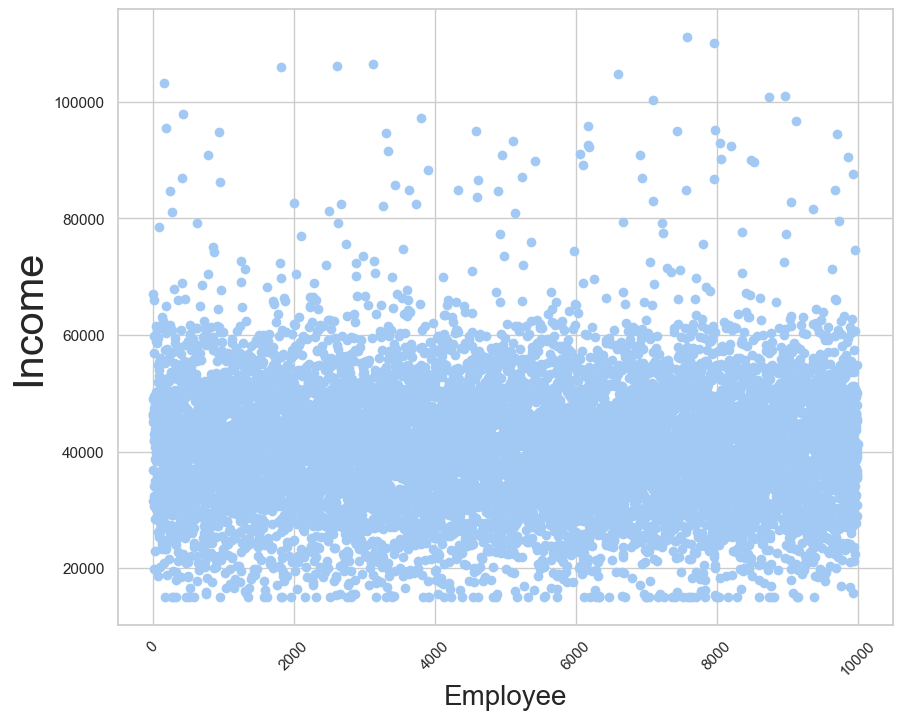

In [187]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(df_empl[criteria], df_empl["income"])
plt.xticks(rotation=45)

plt.xlabel(f"Employee", fontsize=20)
plt.ylabel("Income", fontsize=30)



#### 2. Непараметрическая оценка плотности распределения в виде гистограммы с использованием функции плотности ядра

In [189]:
def cut_tails(array, min_value=5, max_value=95):
    array_cut = []
    q95, q05 = np.percentile(array, [max_value, min_value])
    interval = q95 - q05
    
    min_dist = q05 - (1.5 * interval)
    max_dist = q95 + (1.5 * interval)
    
    for data in array:
        if data < max_dist and data > min_dist:
            array_cut.append(data)
    return array_cut

<AxesSubplot: >

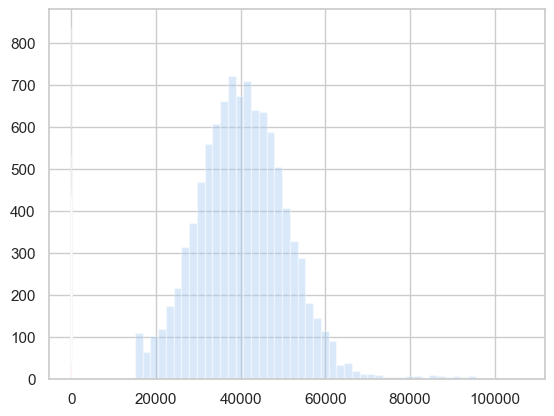

In [190]:
import seaborn as sns

sns.distplot(cut_tails(df_empl["income"]), kde=False)
sns.distplot(cut_tails(source_df["age"]), kde=False)

In [191]:

mean = df_empl["income"].mean()
var = df_empl["income"].var()
std = df_empl["income"].std()
median = df_empl["income"].median()

trunk_mean = scipy.stats.trim_mean(df_empl["income"], proportiontocut=0.1)

def mad(df):
    sigma = 1.2
    k = scipy.stats.lognorm.ppf(3/4., s=sigma)
    median = df.median()

    return k * np.median(np.fabs(df - median))

mad_value = mad(df_empl["income"])
print(f'Average Income Size: Average = {int(mean)}, variance = {int(var)}, standard deviation = {int(std)},\n'
      f'median = {int(median)}, truncated mean {int(trunk_mean)}, MAD = {int(mad_value)}')


mean = source_df["age"].mean()
var = source_df["age"].var()
std = source_df["age"].std()
median = source_df["age"].median()

mad_value = mad(source_df["age"])
print(f'Average Age: Average = {int(mean)}, variance = {int(var)}, standard deviation = {int(std)},\n'
      f'median = {int(median)}, truncated mean {int(trunk_mean)}, MAD = {int(mad_value)}')

Average Income Size: Average = 40556, variance = 119947698, standard deviation = 10952,
median = 40207, truncated mean 40268, MAD = 15568
Average Age: Average = 33, variance = 91, standard deviation = 9,
median = 32, truncated mean 40268, MAD = 13


In [192]:


def sample_mean(df_empl, name):
      norm_q95 = scipy.stats.norm.ppf(0.95)
      mean_conf = norm_q95 * std / np.sqrt(len(df_empl))

      chi2_q95_left = scipy.stats.chi2.ppf((1 - 0.05 / 2.0), df=len(df_empl) - 1)
      chi2_q95_right = scipy.stats.chi2.ppf(0.05 / 2.0, df=len(df_empl) - 1)

      var_conf_left = var * (len(df_empl) - 1) / chi2_q95_left
      var_conf_right = var * (len(df_empl) - 1) / chi2_q95_right

      std_conf_left = np.sqrt(var_conf_left)
      std_conf_right = np.sqrt(var_conf_right)

      print(name, "Sample mean: %0.3f +/- %0.3f" % (mean, mean_conf))
      print(name, "95%% Confidence interval of sample variance : (%0.3f; %0.3f)"
            % (var_conf_left, var_conf_right))
      print(name, "95%% Confidence interval of sample standard deviation: (%0.3f; %0.3f)"
            % (std_conf_left, std_conf_right))

sample_mean(source_df["income"], "income")
sample_mean(source_df["age"], "age")

income Sample mean: 33.187 +/- 0.157
income 95% Confidence interval of sample variance : (88.902; 93.970)
income 95% Confidence interval of sample standard deviation: (9.429; 9.694)
age Sample mean: 33.187 +/- 0.157
age 95% Confidence interval of sample variance : (88.902; 93.970)
age 95% Confidence interval of sample standard deviation: (9.429; 9.694)


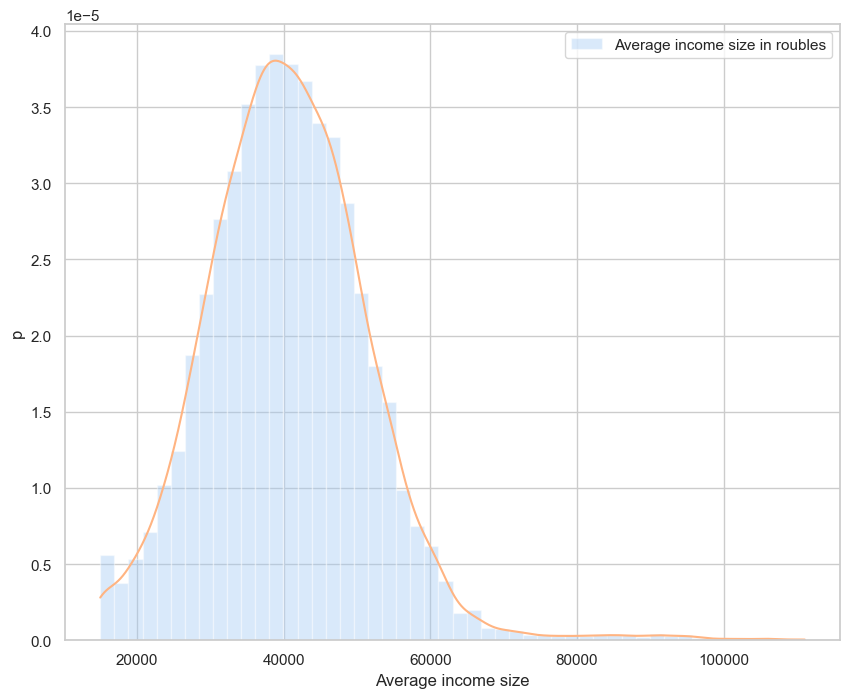

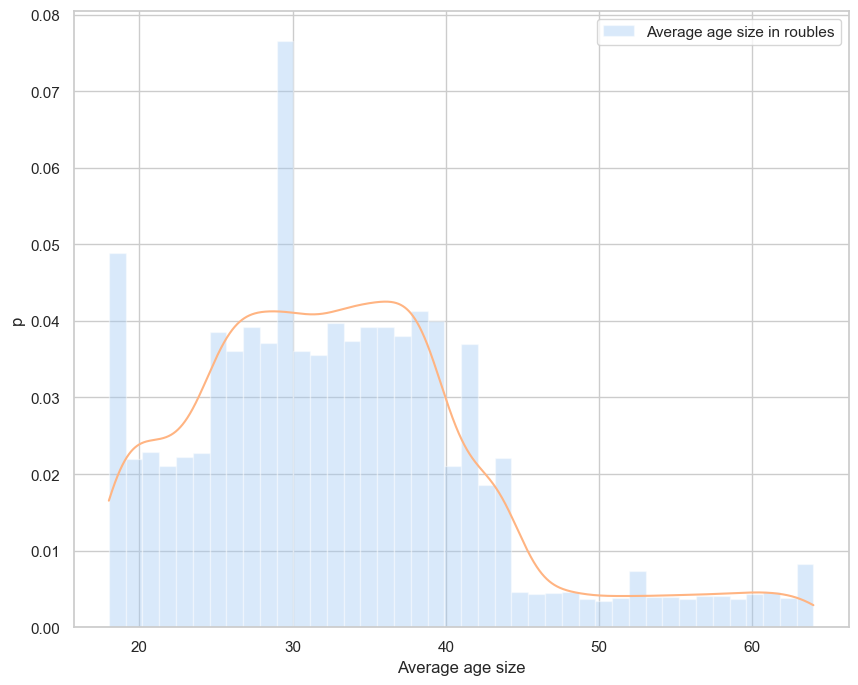

In [193]:
def kern(df_empl, name):
    plt.figure(figsize=(10, 8))

    kernel = scipy.stats.gaussian_kde(df_empl)

    min_price, max_price = df_empl.min(), df_empl.max()
    x = np.linspace(min_price, max_price, len(df_empl))
    kde_values = kernel.evaluate(x)

    sns.distplot(df_empl, kde=False, norm_hist=True, label=f"Average {name} size in roubles")
    plt.plot(x, kde_values)

    plt.ylabel("p")
    plt.xlabel(f"Average {name} size")
    plt.legend()
    plt.show()


kern(source_df["income"], "income")
kern(source_df["age"], "age")

#### 3. Вам необходимо провести оценку порядковых статистик и представить их в виде “ящиков с усами”.

      ID        income  age gender  education_level
2   1996  82606.214973   22      M              2.0
3   9366  81551.229988   36      M              2.0
4   9733  79593.253224   51      M              1.0
27  5972  74374.283991   26      M              1.0
37  2980  73572.547007   31      F              3.0


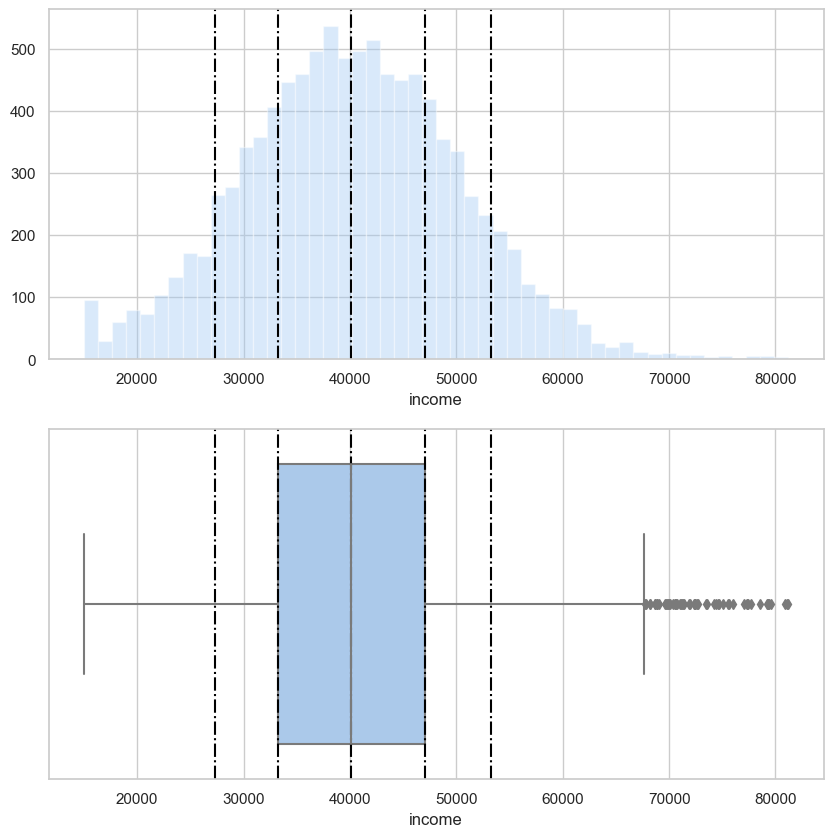

In [194]:
def quantiles(array):
    return np.array([np.quantile(array, percent) for percent in [0.1, 0.25, 0.5, 0.75, 0.9]])


def plot_box(array, label):
    figure, ax = plt.subplots(2, 1, figsize=(10, 10))
    sns.set_theme(style='whitegrid', palette='pastel')
    histplot = sns.distplot(array, ax=ax[0], kde=False)
    boxplot = sns.boxplot(x=array, ax=ax[1])

    histplot.set(xlabel=label)
    boxplot.set(xlabel=label)

    for quiantile in quantiles(array):
        ax[0].axvline(quiantile, color='black', linestyle='-.')
        ax[1].axvline(quiantile, color='black', linestyle='-.')
    
    plt.show()


print(source_df.head())
plot_box(cut_tails(source_df.income, 10, 80), 'income')

In [195]:
pd.Series(cut_tails(source_df.income, 10, 80)).describe()

count     9940.000000
mean     40246.643055
std      10215.283712
min      15000.000000
25%      33262.363930
50%      40120.799897
75%      47035.402165
max      81221.385070
dtype: float64

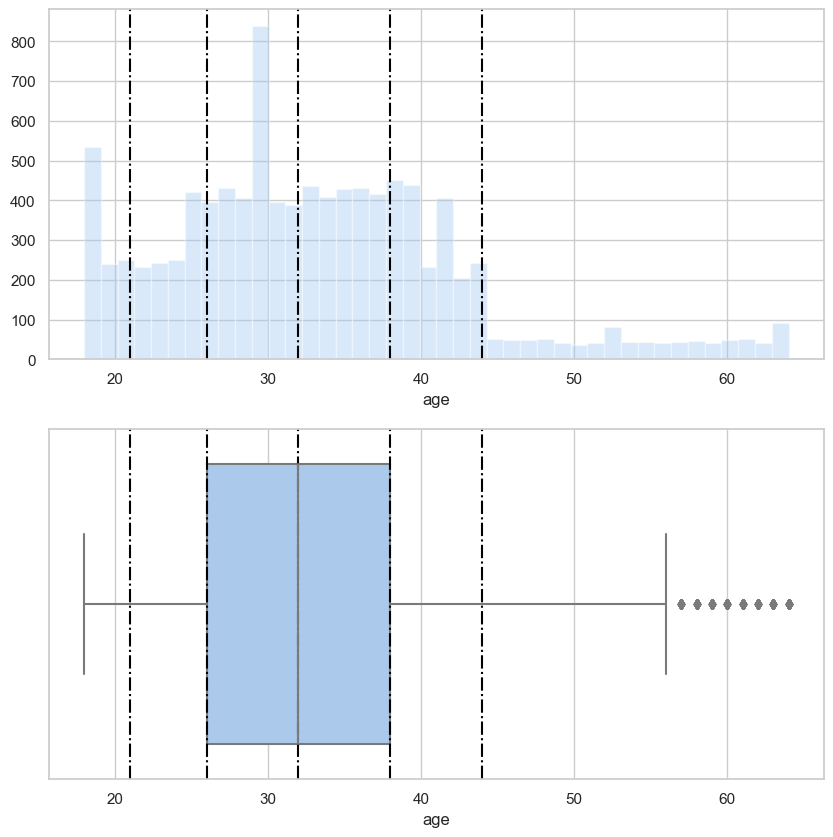

In [196]:
plot_box(cut_tails(source_df.age, 10, 90), 'age')

In [197]:
print(quantiles(source_df.age))
pd.Series(cut_tails(source_df.age, 10, 80)).describe()

[21. 26. 32. 38. 44.]


count    10000.000000
mean        33.186700
std          9.559466
min         18.000000
25%         26.000000
50%         32.000000
75%         38.000000
max         64.000000
dtype: float64

#### 4. Найдите одно или несколько теоретических распределений, которые могли бы описать вашу выборку на основе результатов непараметрического анализа.

In [198]:
methods = {type(d).__name__ : d for d in [
                    scipy.stats.norm, scipy.stats.alpha, scipy.stats.gamma,
                    scipy.stats.beta
                    ]}

def distplot(array, label):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.set_theme(style='whitegrid', palette='pastel')

    subplot = sns.distplot(array, kde=True)
    subplot.set(xlabel=label)


    for name, method in methods.items():
        x_plot = np.linspace(np.min(array), np.max(array), 100)
        args = method.fit(array)
        print(args)
        print("Method: ", name, "args: ", args)
        y_plot = method.pdf(x_plot, *args)
        
        sns.lineplot(x=x_plot, y=y_plot, label=name)
        plt.legend()

(40207.00172674355, 10143.14529336551)
Method:  norm_gen args:  (40207.00172674355, 10143.14529336551)
(13.215500566177209, -92685.2047087109, 1745993.3638526876)
Method:  alpha_gen args:  (13.215500566177209, -92685.2047087109, 1745993.3638526876)
(468.7480729904871, -179404.85160826432, 468.50721074581605)
Method:  gamma_gen args:  (468.7480729904871, -179404.85160826432, 468.50721074581605)
(34.65583839842018, 54.02790414935376, -36733.27366667132, 196888.5444790542)
Method:  beta_gen args:  (34.65583839842018, 54.02790414935376, -36733.27366667132, 196888.5444790542)


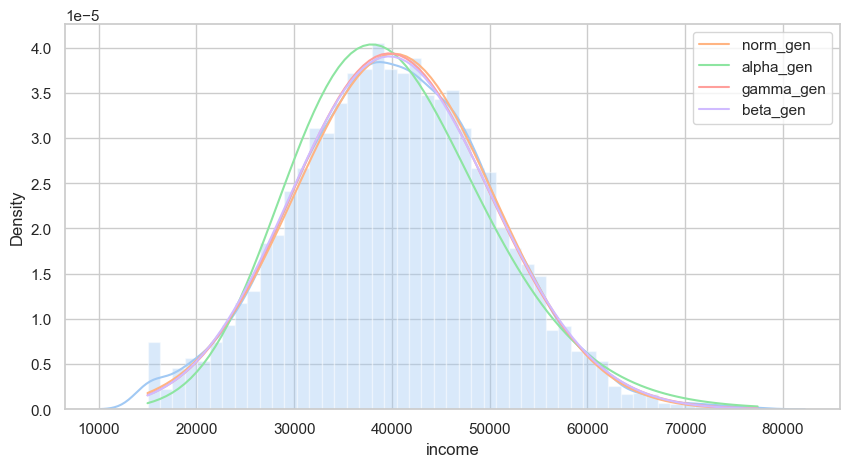

In [199]:
distplot(cut_tails(source_df.income, 15, 80), "income")

#### 5. Оценить параметры выбранных распределений, используя методы максимального правдоподобия и метод наименьших квадратов.

In [661]:
def bfd(name, method):
    income_df = cut_tails(source_df.income, 15, 80)
    # age_df = cut_tails(source_df.age, 15, 80)

    # for norm distribute
    mle = method.fit(income_df, method='MLE')

    ydata, xdata = np.histogram(income_df, bins=100, density=True) #  исходное распределение
    xdata = (xdata + np.roll(xdata, -1))[:-1] / 2.0
    distribution = getattr(scipy.stats, name)
    params = distribution.fit(income_df)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    pdf = distribution.pdf(xdata, loc=loc, scale=scale, *arg)
    ls = np.sum(np.power(ydata - pdf, 2.0))
    return f"least squares: {ls}, likehood {mle}"
# def func(x, a, b): # нормальное распределение
#     return getattr(scipy.stats.distributions, 'beta').pdf(x, a, b)

for name, method in methods.items():
    print(name, bfd(name[:-4], method))



(40207.00172674355, 10143.14529336551)
norm_gen (40207.00172674355, 10143.14529336551)
(13.215500566177209, -92685.2047087109, 1745993.3638526876)
alpha_gen (13.215500566177209, -92685.2047087109, 1745993.3638526876)
(468.7480729904871, -179404.85160826432, 468.50721074581605)
gamma_gen (468.7480729904871, -179404.85160826432, 468.50721074581605)
(34.65583839842018, 54.02790414935376, -36733.27366667132, 196888.5444790542)
beta_gen (34.65583839842018, 54.02790414935376, -36733.27366667132, 196888.5444790542)


#### 6. Проверьте оцененные параметры с помощью графика квантиль-квантиль (QQ).

In [662]:
def biplot(array, method):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    sns.set_theme(style='whitegrid', palette='pastel')

    args = method.fit(array)
    print(f"({type(method).__name__})args: ", args)
    scipy.stats.probplot(array, dist=method, sparams=(args), plot=ax) # сравнение реального распределения данных с распределением method

    ax.get_lines()[0].set_marker('.')
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.75)
    plt.show()

(norm_gen)args:  (40157.24175536075, 10063.293583534713)


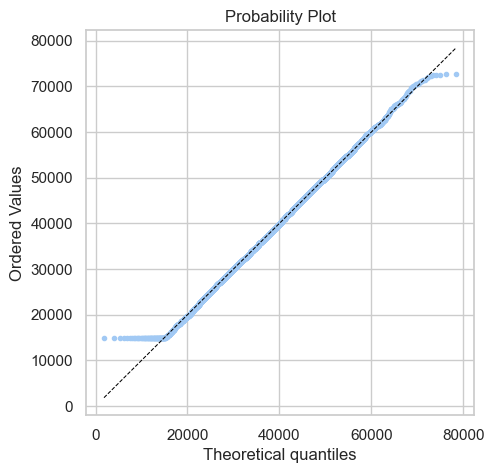

(alpha_gen)args:  (13.952422637465588, -103123.12713959778, 1989587.7768754428)


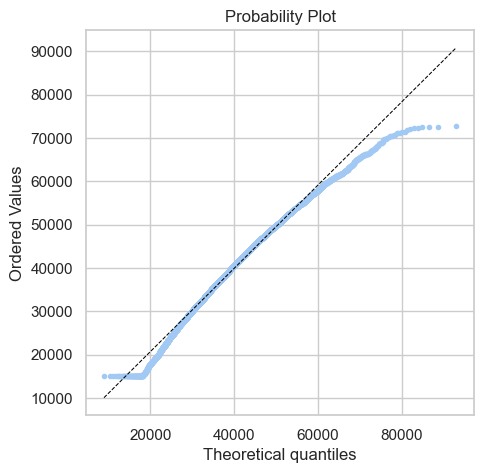

(gamma_gen)args:  (1792.174367242801, -385866.71567808127, 237.7138750680292)


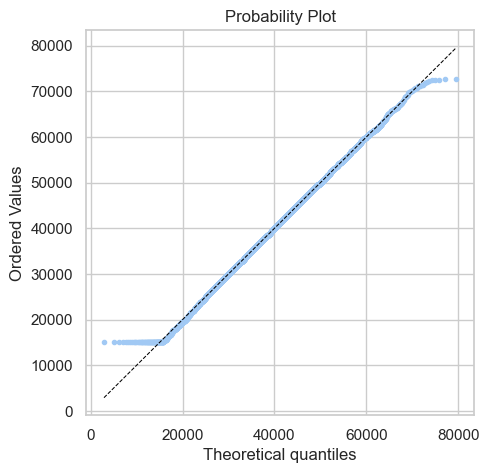

(beta_gen)args:  (14.913163285655564, 17.466070460680957, -13578.078036735336, 116668.15936323203)


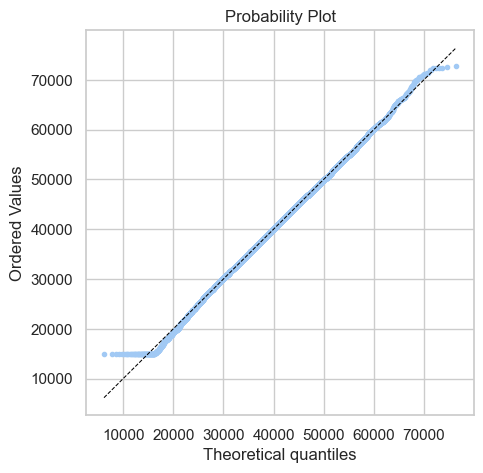

In [663]:
for m in methods.values():
    biplot(cut_tails(source_df.income, 15, 75), method=m)

#### 7. Оценить достоверность подогнанных распределений, используя не менее 2 статистических тестов.

In [664]:
def testing(array, method, cdf):
    args = method.fit(array)

    tests = (scipy.stats.shapiro, scipy.stats.kstest, scipy.stats.anderson)

    result = [
        ("shapiro", scipy.stats.shapiro(array)),
        ("kstest", scipy.stats.kstest(array, cdf=cdf, args=args)),
        ("anderson", scipy.stats.anderson(array)),
        ("cramervonmises", scipy.stats.cramervonmises(array, cdf=cdf, args=args)),
    ]

    return result
            
    


<AxesSubplot: >

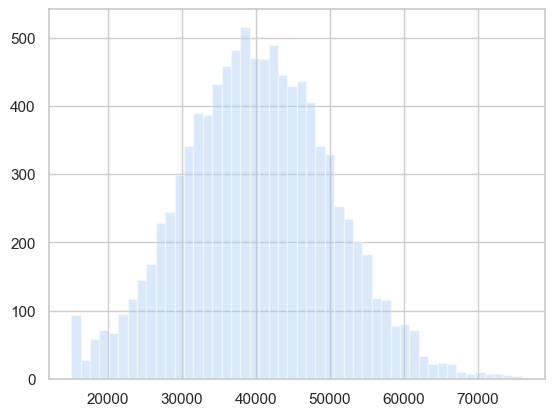

In [665]:
sns.distplot(cut_tails(source_df.income, 10, 75), kde=False)

In [666]:
correct_method = None
max_pvalue = 0
for name, method in methods.items():
    cdf = name[:-4]
    test_res = testing(cut_tails(source_df.income, 10, 75), method=method, cdf=cdf)
    for k in test_res:
        try:
            if max_pvalue < k[1].pvalue:
                max_pvalue = k[1].pvalue 
                correct_method = method
        except Exception:
            pass
        
        print(f"({name} - {k[0]}): {k[1]}")
print(max_pvalue, correct_method)

(norm_gen - shapiro): ShapiroResult(statistic=0.998458743095398, pvalue=2.7070141683793736e-08)
(norm_gen - kstest): KstestResult(statistic=0.007336258193638645, pvalue=0.6565494769994902)
(norm_gen - anderson): AndersonResult(statistic=0.5875301719879644, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
(norm_gen - cramervonmises): CramerVonMisesResult(statistic=0.06547683670702291, pvalue=0.7795959102079226)
(alpha_gen - shapiro): ShapiroResult(statistic=0.998458743095398, pvalue=2.7070141683793736e-08)
(alpha_gen - kstest): KstestResult(statistic=0.035687486502592236, pvalue=2.0294125301789084e-11)
(alpha_gen - anderson): AndersonResult(statistic=0.5875301719879644, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
(alpha_gen - cramervonmises): CramerVonMisesResult(statistic=4.9203339559772425, pvalue=3.695255212932125e-11)
(gamma_gen - shapiro): S

#### 8. Используя одномерные параметрические распределения, которые были подобраны, выполните семплирование СВ. Используйте для этого не менее 2 различных методов семплирования.

Distribution beta_gen arguments: (24.0241488853225, 32.785316836139614, -25669.54075041209, 155741.18673466326)
24.0241488853225 32.785316836139614 -25669.54075041209 155741.18673466326


<AxesSubplot: title={'center': 'accept-reject'}, ylabel='Density'>

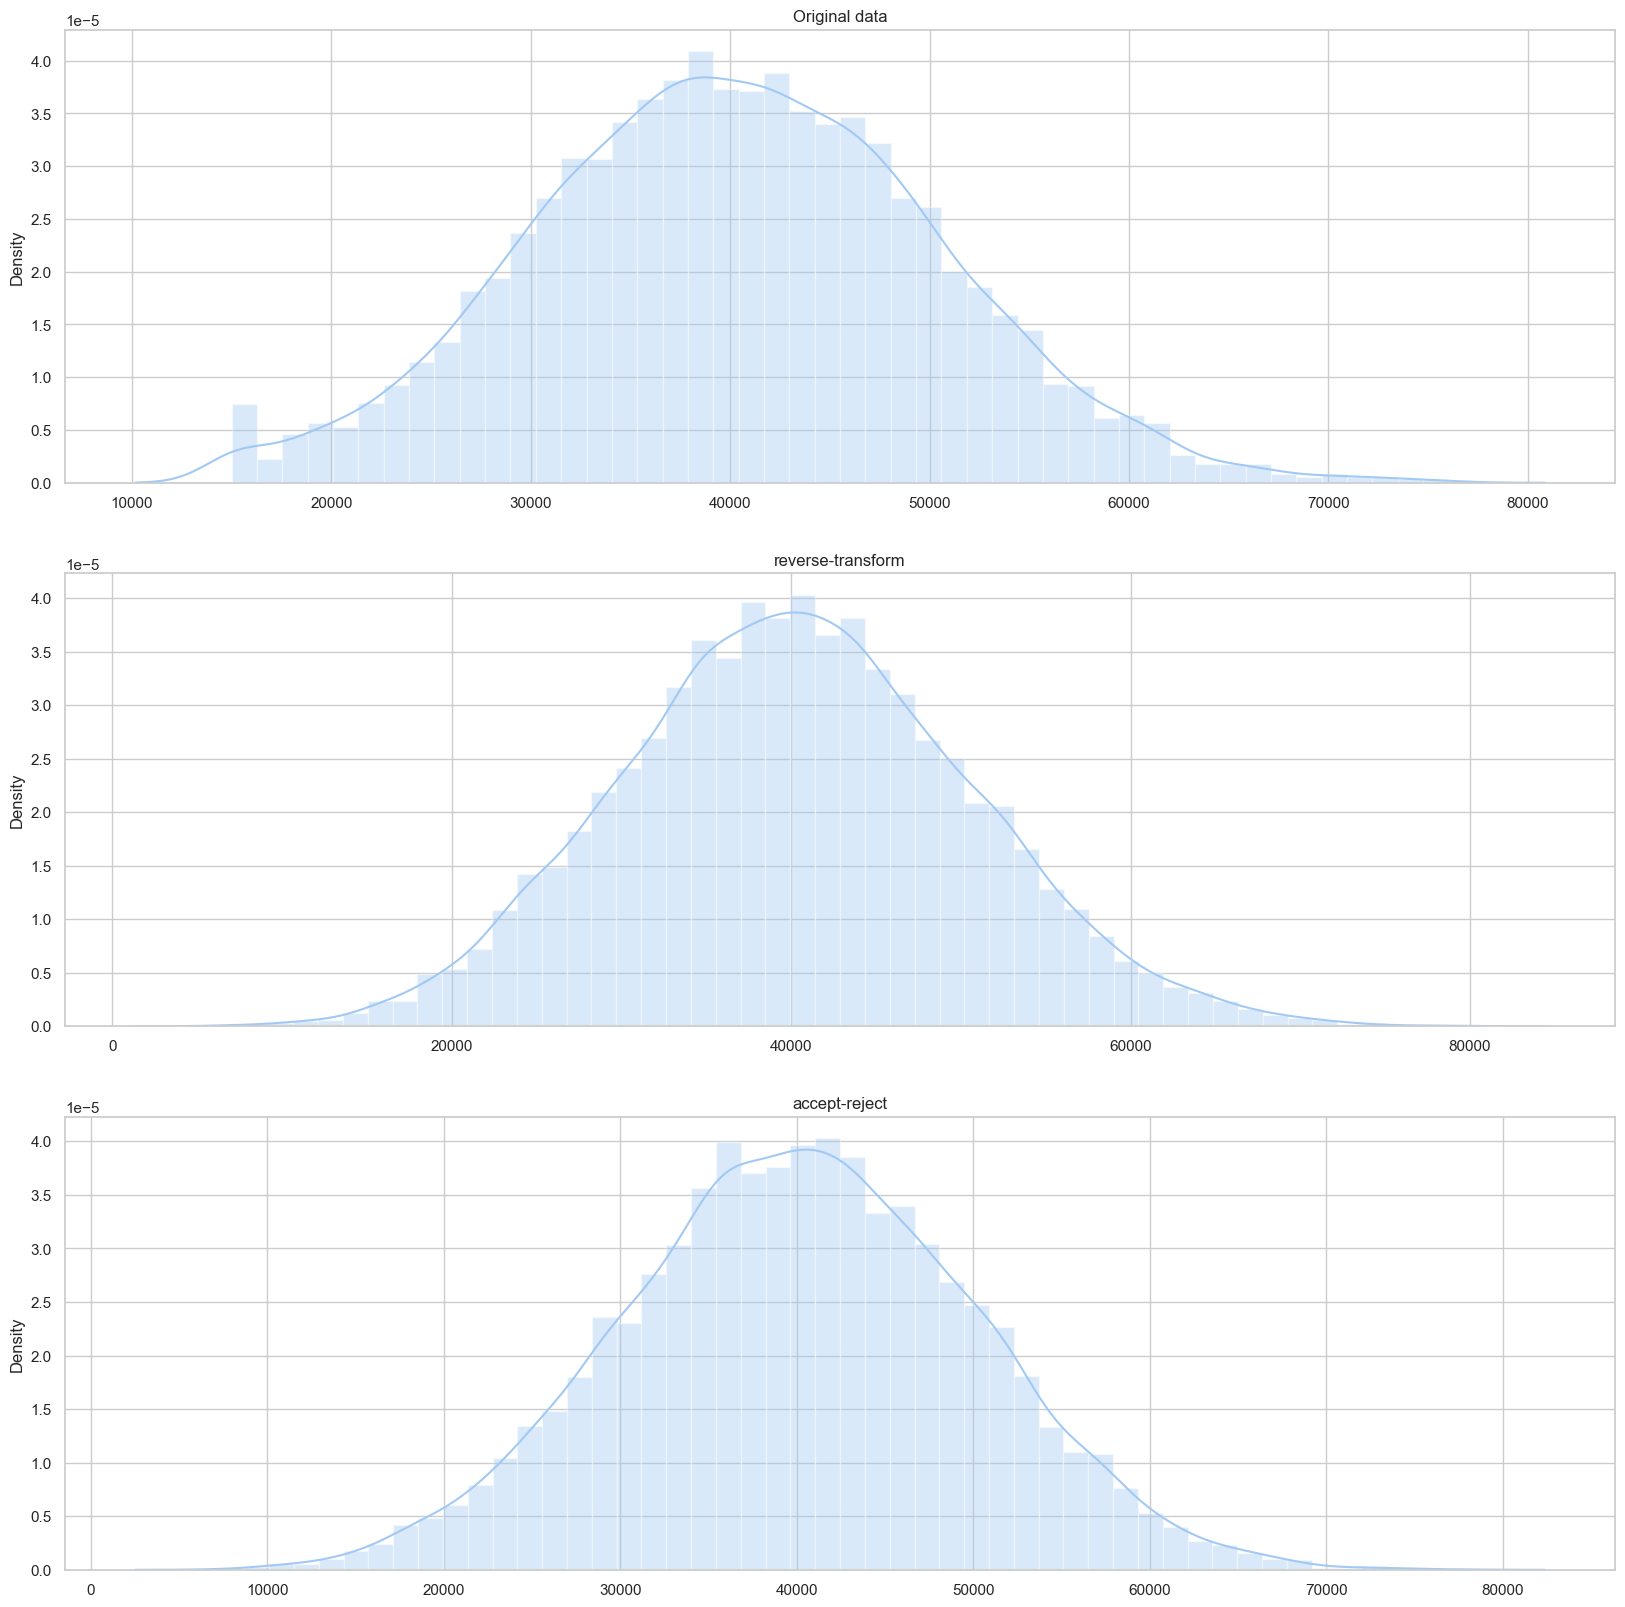

In [667]:
def rt_sampling(array, distribution):
    args = distribution.fit(array)
    print('Distribution', type(distribution).__name__, 'arguments:', args)
    data = np.random.uniform(size=len(array))
    sample = distribution(*args)
    sample = sample.ppf(data)
    return sample


def ar_sampling(array, distribution):
    dstr = distribution.fit(array)
    print(*dstr)
    sample = distribution.rvs(*dstr, size=len(array))
    return sample

sns.set_theme(style='whitegrid', palette='pastel')
figure, ax = plt.subplots(3,1, figsize=(20, 20))
ax[0].set_title("Original data")
ax[1].set_title("reverse-transform")
ax[2].set_title("accept-reject")

tmp_df = cut_tails(source_df.income, 10, 75)
sns.distplot(tmp_df, ax=ax[0], kde=True)
sns.distplot(rt_sampling(tmp_df, correct_method), ax=ax[1], kde=True)
sns.distplot(ar_sampling(tmp_df, correct_method), ax=ax[2], kde=True)